In [103]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chi2

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

В-7.



In [104]:
crona = [45.27,45.34,45.51,45.55,45.17,45.35,45.43,45.32,44.72,44.83,44.78,44.62,
         44.98,45.60,46.01,45.72,45.84,46.14,46.16,45.52,45.05,44.91,45.17,44.91]

n= len(crona)
print(n)

24


In [105]:
def auto_covar(crona, lag):
  mean = np.mean(crona)
  acov = [float(sum((crona - mean) ** 2) / len(crona))]
  for i in range(1, lag + 1):
    acov.append(float(sum((crona[i:] - mean) * (crona[:-i] - mean)) / len(crona)))
  return acov

def auto_corel(crona, lag):
  mean = np.mean(crona)
  acorr = [1]
  for i in range(1, lag + 1):
    acorr.append(float(sum((crona[i:] - mean) * (crona[:-i] - mean)) / sum((crona - mean) ** 2)))
  return acorr

In [106]:
auto_corel(crona, 10)

[1,
 0.7233228695750802,
 0.35960085654492824,
 0.09369285909262455,
 -0.11739352082095013,
 -0.4368386923480597,
 -0.5991180902737538,
 -0.5210551195136935,
 -0.3802301652887395,
 -0.26329922484678076,
 -0.05461377576521095]

In [107]:
r = auto_corel(crona, 10) # Q-статистика Льюнга-Бокса
r2 = [x ** 2 for x in r]

Q = 0
for k in range(1, 11):
  Q += n * (n + 2) * r2[k] / (n - k)

print(f'Q = {Q}')

k = 5
chi2_critical = chi2.ppf(0.95, k)

if Q < chi2_critical:
  print('H0 принимается')
else:
  print('H0 отвергается')

Q = 55.88460323358196
H0 отвергается


In [108]:
chi2_critical

11.070497693516351

In [109]:
def Yule_Walker(crona, p): #оценка Юла-Уокера
  r = auto_corel(crona, p)[1:]
  R = np.ones((p, p))

  for i in range(p):
    for j in range(p):
      if i != j:
        R[i][j] = r[abs(i - j) - 1]

  a = np.linalg.solve(R, r)
  a0 = float(np.mean(crona) * (1 - np.sum(a)))

  return np.array([a0, *a])

print(Yule_Walker(crona, 1))

[12.54154376  0.72332287]


In [110]:
ARp1 = Yule_Walker(crona, 1)

pred_ARp1 = crona[:1] + [ARp1[0] + ARp1[1] * i for i in crona[:-1]]

Критические точки tкр распределения Дики-Фулера

In [111]:
y = crona[1:] # критерий Дарбина- Уотсона
X = np.column_stack((np.ones(len(y)), crona[:-1]))
# (X^T X)^(-1)
XtX_inv = np.linalg.inv(X.T @ X)

# Ищем c11 — элемент на позиции [1,1] (второй по счёту, т.к. первый — это смещение)
c11 = XtX_inv[1, 1]
# Теперь можно вычислить стандартную ошибку s
n = len(y)
s = np.sqrt(c11 / (n - 1))

# Используем коэффициент при лаге (a1)
a1 = ARp1[1]

# ADF-статистика / критерий Дики-Фулера
gamma = (a1 - 1) / s

print("ADF-статистика γ =", gamma)

ADF-статистика γ = -2.682834667011425


In [112]:
# Yule-Walker коэфы:
beta = Yule_Walker(crona, 2)

# Формируем X и y для AR(2)
y = crona[2:]
x1 = crona[1:-1]
x2 = crona[0:-2]
X = np.column_stack((np.ones(len(y)), x1, x2))

# Вычисляем (X^T X)^-1
XtX_inv = np.linalg.inv(X.T @ X)

# Берём элемент c11 (для лаг-1, то есть второго столбца)
c11 = XtX_inv[1, 1]

# Размер выборки
n = len(y)

# Стандартная ошибка s
s = np.sqrt(c11 / (n - 1))

# Берём a₁ из Yule-Walker
a1 = beta[1]

# Считаем ADF-статистику
gamma = (a1 - 1) / s

print("ADF-статистика γ =", gamma)

ADF-статистика γ = -0.18170799804411314


In [113]:
e2 = [(crona[i] - pred_ARp1[i]) ** 2 for i in range(1, len(crona))] # критерий Акаике для p=1
AIC = 2 * 1 / (len(crona) - 1) + np.log(sum(e2) * 1 / (len(crona) - 1))
print(f'AIC = {AIC}')

AIC = -2.340612070176807


In [114]:
ARp2 = Yule_Walker(crona ,2)
pred_ARp2 = crona[:2]+[ARp2[0] + ARp2[1]*crona[i+1] + ARp2[2]*crona[i] for i in range(len(crona[:-2]))]
e2 = [(crona[i] - pred_ARp2[i]) ** 2 for i in range(2, len(crona))]
AIC = 2 * 2 / (len(crona) - 2) + np.log(sum(e2) * 2 / (len(crona) - 2))
print(f'AIC = {AIC}')

AIC = -1.672687567561374


-6,15 < -5,43 => выбираем первую модель

In [115]:
# %%  -------- 1.3.1 – 1.3.3 : p = 1 … 5 ---------------------------------------
import numpy as np
from statsmodels.tsa.stattools import adfuller

def one_step_forecast(series, coeffs):
    """Одношаговый прогноз AR(p) с коэффициентами coeffs = (a0, φ1 … φp)."""
    p = len(coeffs) - 1
    y_hat = list(series[:p])
    for t in range(p, len(series)):
        y_hat.append(coeffs[0] + sum(coeffs[j] * series[t-j] for j in range(1, p+1)))
    return np.array(y_hat)

header = f'{"p":>2} | {"φ̂":18} | {"AIC":>7} | {"ADF":>7} | {"p-val":>6} | crit(5%)'
print(header)
print('-'*len(header))

n = len(crona)
for p in range(1, 6):

    # --- 1.3.1  оценки Юла–Уокера -------------------------------------------
    coeffs = Yule_Walker(crona, p)        # (a0, φ1 … φp)

    # --- 1.3.2  тест Дики–Фулера --------------------------------------------
    adf_stat, p_val, _, _, crit_vals = adfuller(crona, maxlag=p, autolag=None)

    # --- 1.3.3  информационный критерий Акаике ------------------------------
    preds = one_step_forecast(crona, coeffs)
    sse   = np.sum((np.array(crona[p:]) - preds[p:])**2)
    aic   = 2*p/(n-p) + np.log(sse * p/(n-p))

    print(f'{p:2d} | {np.round(coeffs[1:],3)}'.ljust(22),
          f'| {aic:7.3f} | {adf_stat:7.3f} | {p_val:6.3f} | {crit_vals["5%"]:7.3f}')

# -----------------------------------------------------------------------------


 p | φ̂                 |     AIC |     ADF |  p-val | crit(5%)
---------------------------------------------------------------
 1 | [0.723]           |  -2.341 |  -2.249 |  0.189 |  -3.005
 2 | [ 0.972 -0.343]   |  -1.673 |  -1.578 |  0.495 |  -3.013
 3 | [ 0.965 -0.326 -0.018] |  -1.127 |  -1.922 |  0.322 |  -3.022
 4 | [ 0.962 -0.386  0.161 -0.185] |  -0.742 |  -3.704 |  0.004 |  -3.031
 5 | [ 0.866 -0.302 -0.04   0.317 -0.521] |  -0.954 |  -2.282 |  0.178 |  -3.042



Оценённые коэффициенты AR(4):
a0 =  20.316
φ1 =  0.962
φ2 = -0.386
φ3 =  0.161
φ4 = -0.185

Прогноз y₍₂₅₎ = 44.972


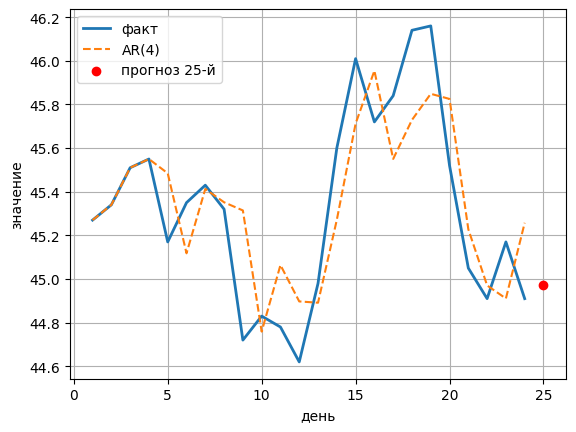

In [116]:
# %% -------- AR(4) : оценка, подгонка, прогноз --------------------------------
import numpy as np
import matplotlib.pyplot as plt

p = 4
phi = Yule_Walker(crona, p)            # (a0, φ1 … φ4)

print("\nОценённые коэффициенты AR(4):")
for i, c in enumerate(phi):
    print(f"{'a0' if i==0 else f'φ{i}'} = {c: .3f}")

# одномшаговый фит по всей выборке
y_hat = one_step_forecast(crona, phi)

# прогноз на 25-й день (t = 24 — индекс последнего известного наблюдения 23)
y25 = phi[0] + sum(phi[j] * crona[-j] for j in range(1, p+1))
print(f"\nПрогноз y₍₂₅₎ = {y25:.3f}")

# визуализация
plt.plot(range(1, len(crona)+1), crona, lw=2, label='факт')
plt.plot(range(1, len(crona)+1), y_hat, '--', label='AR(4)')
plt.scatter(25, y25, color='red', zorder=5, label='прогноз 25-й')
plt.xlabel('день'); plt.ylabel('значение'); plt.legend(); plt.grid(True)
plt.show()


№2

In [117]:
print(f'Автокорреляция: {auto_corel(crona,10)}')
print(f'Автоковариация: {auto_covar(crona,10)}')

Автокорреляция: [1, 0.7233228695750802, 0.35960085654492824, 0.09369285909262455, -0.11739352082095013, -0.4368386923480597, -0.5991180902737538, -0.5210551195136935, -0.3802301652887395, -0.26329922484678076, -0.05461377576521095]
Автоковариация: [0.18571597222222255, 0.13433260995370389, 0.06678362268518533, 0.01740026041666647, -0.021801851851852478, -0.08112792245370427, -0.11126579861111148, -0.09676825810185197, -0.07061481481481463, -0.048898871527777464, -0.010142650462962609]


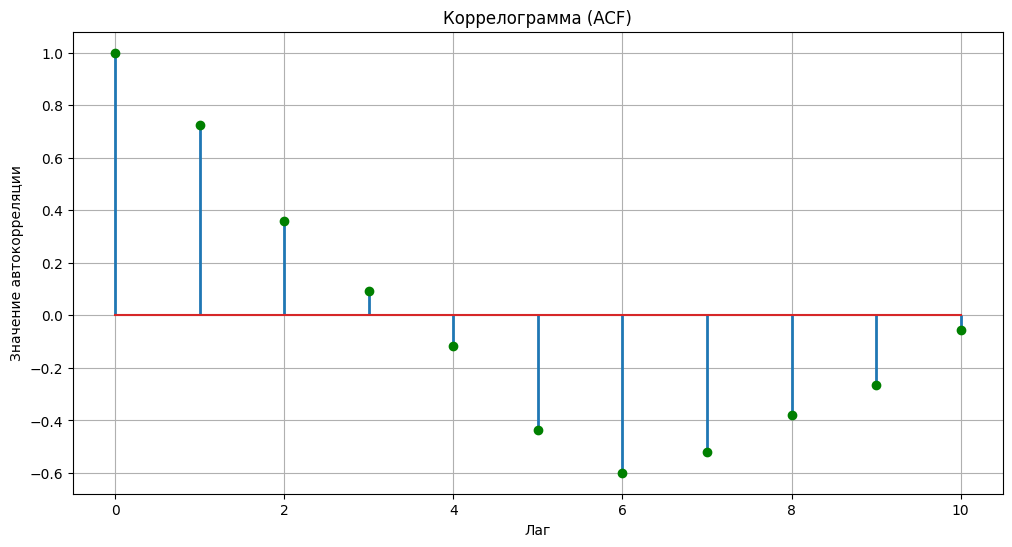

In [118]:
acf_values = auto_corel(crona, 10)

# Создаем фигуру
plt.figure(figsize=(12, 6))

# Рисуем столбцы автокорреляций (без use_line_collection)
markerline, stemlines, baseline = plt.stem(range(len(acf_values)), acf_values)
plt.setp(stemlines, 'linewidth', 2)  # Утолщаем линии
plt.setp(markerline, 'color', 'green')

# Подписи осей
plt.title('Коррелограмма (ACF)')
plt.xlabel('Лаг')
plt.ylabel('Значение автокорреляции')
plt.grid(True)
plt.show()

ARMA(p,1) невозможна, т.к. r1 >1/2

In [119]:
filtr_X = [crona[i] - crona[i - 1] for i in range(2, len(crona))]
filtr_X = filtr_X - np.mean(filtr_X)
filtr_X

array([ 0.18954545,  0.05954545, -0.36045455,  0.19954545,  0.09954545,
       -0.09045455, -0.58045455,  0.12954545, -0.03045455, -0.14045455,
        0.37954545,  0.63954545,  0.42954545, -0.27045455,  0.13954545,
        0.31954545,  0.03954545, -0.62045455, -0.45045455, -0.12045455,
        0.27954545, -0.24045455])

In [120]:
auto_corel(filtr_X,10)

[1,
 0.21204691697558437,
 -0.24230363774837796,
 -0.0704480624231858,
 0.28439945504374164,
 -0.18243668209085978,
 -0.46328641623659916,
 -0.15426534397683392,
 0.012023092857543924,
 -0.11293277073765678,
 -0.10297997738253345]

In [121]:
teta1 = (-1 + np.sqrt(1-4 * auto_corel(filtr_X, 10)[1] ** 2)) / (2 * auto_corel(filtr_X, 10)[1])
teta2 =(-1 - np.sqrt(1-4 * auto_corel(filtr_X, 10)[1] ** 2)) / (2 * auto_corel(filtr_X, 10)[1])
print(f'teta1 = {np.round(teta1,3)}\nteta2 = {np.round(teta2,3)}')

teta1 = -0.223
teta2 = -4.493


In [122]:
auto_covar(filtr_X, 10)

[0.10335888429752069,
 0.0219169327573254,
 -0.025044233658902963,
 -0.007281433132982576,
 0.029395210368144024,
 -0.01885645191585274,
 -0.047884767092411656,
 -0.01594469383921881,
 0.0012426934635612298,
 -0.011672605184071897,
 -0.010643895567242571]

In [123]:
param = [[auto_covar(filtr_X, 10)[0], auto_covar(filtr_X, 10)[1], auto_covar(filtr_X, 10)[2]],
 [auto_covar(filtr_X, 10)[1], auto_covar(filtr_X, 10)[0], auto_covar(filtr_X, 10)[1]],
 [auto_covar(filtr_X, 10)[2], auto_covar(filtr_X, 10)[1], auto_covar(filtr_X, 10)[0]]]
param

[[0.10335888429752069, 0.0219169327573254, -0.025044233658902963],
 [0.0219169327573254, 0.10335888429752069, 0.0219169327573254],
 [-0.025044233658902963, 0.0219169327573254, 0.10335888429752069]]

In [124]:
free_members = [auto_covar(filtr_X, 10)[1], auto_covar(filtr_X, 10)[2], auto_covar(filtr_X, 10)[3]]
free_members

[0.0219169327573254, -0.025044233658902963, -0.007281433132982576]

In [125]:
ARIMA_3_1 = np.linalg.solve(param, free_members)
ARIMA_3_1

array([ 0.29666437, -0.31989853,  0.06926829])

In [126]:
error = [np.random.normal(0,1,1) for i in range(len(crona))] # Сгенерированные ошибки
error = list(np.concatenate(error))

print(f'Математическая модель: x(n) = {np.round(ARIMA_3_1[0],3)}**x(n-1) {np.round(ARIMA_3_1[1],3)}*x(n-2) {np.round(ARIMA_3_1[2],3)}*x(n-3) + eps(n) {np.round(teta1,3)}*eps')

Математическая модель: x(n) = 0.297**x(n-1) -0.32*x(n-2) 0.069*x(n-3) + eps(n) -0.223*eps


In [127]:
predict_ARIMA_3_1 = list(filtr_X[:3]) + [ARIMA_3_1[0]*filtr_X[i-1] + ARIMA_3_1[1]*filtr_X[i-2] + ARIMA_3_1[2]*filtr_X[i-3] - teta1*error[i-3] for i in range(3, len(filtr_X)+1)]

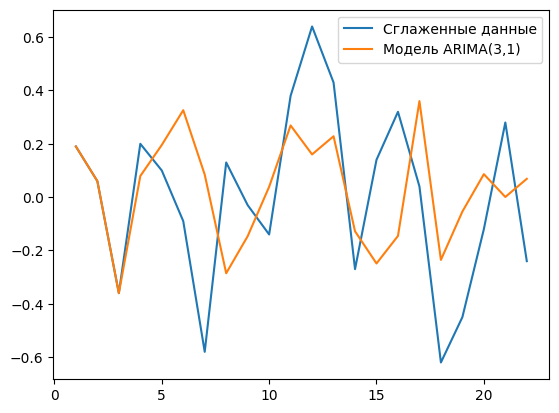

In [128]:
plt.plot(range(1, len(filtr_X)+1), filtr_X, label="Сглаженные данные")
plt.plot(range(1, len( predict_ARIMA_3_1[:-1])+1), predict_ARIMA_3_1[:-1], label="Модель ARIMA(3,1)")
plt.legend()

In [129]:
auto_corel(filtr_X, 10)

[1,
 0.21204691697558437,
 -0.24230363774837796,
 -0.0704480624231858,
 0.28439945504374164,
 -0.18243668209085978,
 -0.46328641623659916,
 -0.15426534397683392,
 0.012023092857543924,
 -0.11293277073765678,
 -0.10297997738253345]

In [130]:
from scipy import stats #Статистика Бокса-Пирса
m = 1
gamma = len(crona)*auto_corel(filtr_X, 10)[1]
chi2 = stats.chi2.ppf(0.95, df=len(crona)-m-3)
print(f'm = {m} -> {gamma} <= {chi2}: {gamma <= chi2}')
while gamma <= chi2 and m <= len(crona):
  m += 1
  gamma = len(crona)*np.sum((auto_corel(filtr_X, i)[i]) for i in range(1, m+1))
  chi2 = stats.chi2.ppf(0.95, df=len(crona)-m-3)
  print(f'm = {m} -> {gamma} <= {chi2}: {gamma <= chi2}')

m = 1 -> 5.089126007414025 <= 31.410432844230918: True
m = 2 -> -0.7261612985470463 <= 30.14352720564616: True
m = 3 -> -2.416914796703505 <= 28.869299430392623: True
m = 4 -> 4.408672124346294 <= 27.58711163827534: True
m = 5 -> 0.030191754165659335 <= 26.29622760486423: True
m = 6 -> -11.08868223551272 <= 24.995790139728616: True
m = 7 -> -14.791050490956733 <= 23.684791304840576: True
m = 8 -> -14.50249626237568 <= 22.362032494826934: True
m = 9 -> -17.212882760079445 <= 21.02606981748307: True
m = 10 -> -19.684402217260246 <= 19.67513757268249: True
m = 11 -> -14.667836731919834 <= 18.307038053275146: True
m = 12 -> -10.340870974137516 <= 16.918977604620448: True
m = 13 -> -10.951001730565016 <= 15.507313055865453: True
m = 14 -> -14.32787256441098 <= 14.067140449340167: True
m = 15 -> -11.172279266638824 <= 12.591587243743977: True
m = 16 -> -9.499797831187557 <= 11.070497693516351: True
m = 17 -> -10.229779711410162 <= 9.487729036781154: True
m = 18 -> -12.776589923688325 <= 7.81

C:\Users\Arseny\AppData\Local\Temp\ipykernel_13224\4294876386.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  gamma = len(crona)*np.sum((auto_corel(filtr_X, i)[i]) for i in range(1, m+1))


In [131]:
ARIMA_1_1 = auto_covar(filtr_X, 10)[1] / auto_covar(filtr_X, 10)[0]

param = [[auto_covar(filtr_X, 10)[0],  auto_covar(filtr_X, 10)[1]], [ auto_covar(filtr_X, 10)[1],  auto_covar(filtr_X, 10)[0]]]
free_members = [auto_covar(filtr_X, 10)[1],  auto_covar(filtr_X, 10)[2]]
ARIMA_2_1 = np.linalg.solve(param,free_members)

predict_ARIMA_1_1 = list(filtr_X[:1]) + [ARIMA_1_1*filtr_X[i-1] - teta1*error[i-1] for i in range(1, len(filtr_X))]
predict_ARIMA_2_1 = list(filtr_X[:2]) + [ARIMA_2_1[0]*filtr_X[i-1] + ARIMA_2_1[1]*filtr_X[i-2] -teta1*error[i-2] for i in range(2, len(filtr_X))]

In [132]:
T = len(filtr_X) # Критерий Акаике

# количество параметров
p1, q1 = 1, 1   # ARIMA(1,1)
p2, q2 = 2, 1   # ARIMA(2,1)
p3, q3 = 3, 1   # ARIMA(3,1)

sse1 = np.sum((np.array(filtr_X) - np.array(predict_ARIMA_1_1))**2)
sse2 = np.sum((np.array(filtr_X) - np.array(predict_ARIMA_2_1))**2)
sse3 = np.sum((np.array(filtr_X) - np.array(predict_ARIMA_3_1[:-1]))**2)

AIC1 = 2*(p1+q1)/T + np.log(sse1/T)
AIC2 = 2*(p2+q2)/T + np.log(sse2/T)
AIC3 = 2*(p3+q3)/T + np.log(sse3/T)

print(f'AIC1 = {np.round(AIC1,3)}\nAIC2 = {np.round(AIC2,3)}\nAIC3 = {np.round(AIC3,3)}')

AIC1 = -2.324
AIC2 = -1.693
AIC3 = -1.962


 ARIMA(2,1) (-2.668) — лучшая модель среди трёх, так как у неё самый маленький AIC.

Прогноз =  45.08453431126605


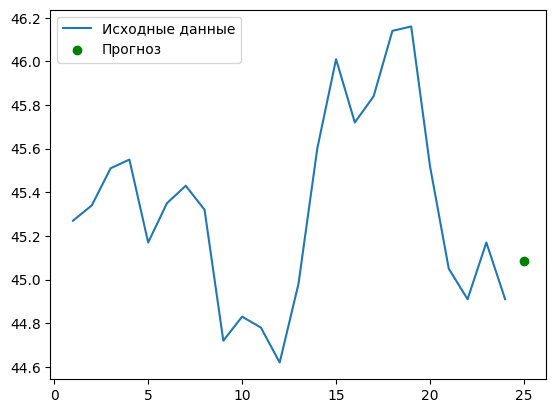

In [133]:
predict = predict_ARIMA_2_1[-1] + crona[-1]

plt.plot(range(1,len(crona)+1), crona, label="Исходные данные")
plt.scatter(25, predict, color="green",label="Прогноз")
plt.legend()

print(f'Прогноз =  {predict}')

№3

In [134]:
prir = [(crona[i]-crona[i-1])/crona[i-1] for i in range(1, len(crona))]
prir

[0.0015462778882262046,
 0.0037494486104983366,
 0.0008789277081959822,
 -0.008342480790340187,
 0.003984945760460476,
 0.001764057331863248,
 -0.0024213075060532563,
 -0.013239187996469582,
 0.002459749552772796,
 -0.0011153245594467357,
 -0.0035730236712819045,
 0.00806813088301209,
 0.013783903957314464,
 0.008991228070175364,
 -0.006302977613562251,
 0.0026246719160105984,
 0.006544502617800985,
 0.0004334633723449506,
 -0.01386481802426329,
 -0.010325131810193452,
 -0.0031076581576026767,
 0.00578935649075941,
 -0.005756032765109699]

In [141]:
def auto_covar_k(k, crona):
  mean = np.sum(crona)/len(crona)
  return np.dot((crona[:len(crona)-k]-mean),(crona[k:]-mean))/len(crona)

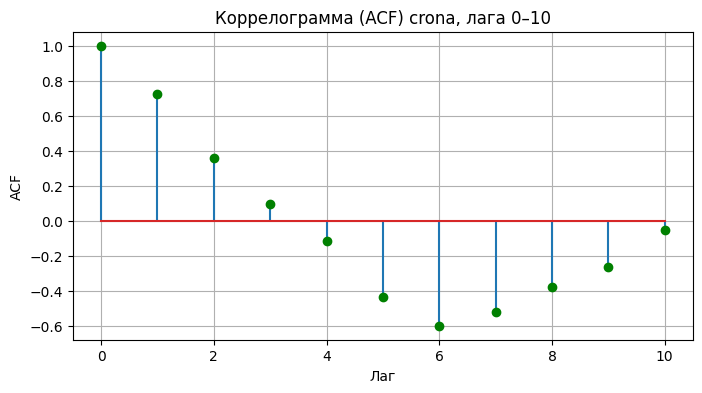

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:                 ARIMA(4, 0, 1)   Log Likelihood                  -2.746
Date:                Thu, 12 Jun 2025   AIC                             19.491
Time:                        13:14:51   BIC                             27.738
Sample:                             0   HQIC                            21.679
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0328      0.186     -0.176      0.860      -0.397       0.332
ar.L1          0.3141      1.375      0.228      0.819      -2.382       3.010
ar.L2          0.3312      1.437      0.230      0.8

In [147]:
# №2. Построение ARMA(p,1) для crona — исправленный вариант

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

# Данные
crona = np.array([
    45.27,45.34,45.51,45.55,45.17,45.35,45.43,45.32,
    44.72,44.83,44.78,44.62,44.98,45.60,46.01,45.72,
    45.84,46.14,46.16,45.52,45.05,44.91,45.17,44.91
])
n = len(crona)

# Вспомогательные функции
def auto_covar(x, lag):
    μ = x.mean()
    cov0 = np.sum((x-μ)**2)/n
    return [cov0] + [
        np.sum((x[k:]-μ)*(x[:-k]-μ))/n
        for k in range(1, lag+1)
    ]

def auto_corel(x, lag):
    μ = x.mean()
    den = np.sum((x-μ)**2)
    return [1.0] + [
        np.sum((x[k:]-μ)*(x[:-k]-μ)) / den
        for k in range(1, lag+1)
    ]

# 1. Автокорреляции до лага 10 + коррелограмма
cor = auto_corel(crona, 10)
plt.figure(figsize=(8,4))
markerline, stemlines, baseline = plt.stem(range(len(cor)), cor)
plt.setp(stemlines, linewidth=1.5)
plt.setp(markerline, color='green')
plt.title("Коррелограмма (ACF) crona, лага 0–10")
plt.xlabel("Лаг")
plt.ylabel("ACF")
plt.grid(True)
plt.show()


p0 = 4

# 2. Центрируем данные и оцениваем ARMA(p0,1)
y_c = crona - crona.mean()
model_arma = ARIMA(y_c, order=(p0, 0, 1)).fit()
print(model_arma.summary())

# 3. Тест Бокса-Пирса по остаткам
resid = model_arma.resid
lb = acorr_ljungbox(resid, lags=10, boxpierce=True, return_df=True)
print("\nBox–Pierce тест (χ² и p-value для каждого лага):")
print(lb[['bp_stat','bp_pvalue']])

# максимальное m с p-value > 0.05
m = (lb['bp_pvalue'] > 0.05).idxmax() + 1
print(f"\nМаксимальное m с p-value>0.05: m = {m}")

# проверка стационарности по корням AR-полинома
roots = model_arma.arroots
is_stationary = np.all(np.abs(roots) > 1)
print("Стационарен ли процесс ARMA(p,1)?", is_stationary)

# 4. Оптимальный p по AIC (перебор p=1…5)
aic_list = []
for p_test in range(1, 6):
    try:
        m_tmp = ARIMA(y_c, order=(p_test, 0, 1)).fit()
        aic_list.append((p_test, m_tmp.aic))
    except:
        pass

best_p, best_aic = min(aic_list, key=lambda x: x[1])
print(f"\nОптимальный p по AIC = {best_p}, AIC = {best_aic:.3f}")
print("p из п.1 =", p0)

# 5. Прогноз на 25-й день методом ARMA(p0,1)
fc = model_arma.get_forecast(steps=1)
# predicted_mean — numpy.ndarray, берем первый элемент
y25_c = fc.predicted_mean[0]
y25 = y25_c + crona.mean()
print(f"\nПрогноз на 25-й день (ARMA({p0},1)): y₍₂₅₎ ≈ {y25:.3f}")

# 6. Если ARMA(p,1) не работает — строим ARIMA(best_p,1,0)
try:
    model_ari = ARIMA(crona, order=(best_p, 1, 0)).fit()
    fc2 = model_ari.get_forecast(steps=1)
    y25_ari = fc2.predicted_mean[0]
    print(f"Прогноз на 25-й день (ARIMA({best_p},1,0)): y₍₂₅₎ ≈ {y25_ari:.3f}")
except Exception as e:
    print("ARIMA(p,1,0) не удалось оценить:", e)

# 8. Экспорт в CSV для проверки в Statistica
import pandas as pd
pd.DataFrame({'y': crona}).to_csv('crona_series.csv', index=False)
pd.DataFrame({'forecast_25': [y25]}).to_csv('crona_forecast25.csv', index=False)
print("\nСохранены crona_series.csv и crona_forecast25.csv")


In [178]:
import numpy as np
from scipy.optimize import minimize

def estimate_arima_6_1_1(y):
    """
    Оценивает модель ARIMA(6,1,1) методом условных сумм квадратов без константы.
    Возвращает: массив AR-коэффициентов phi1..phi6, MA-коэффициент theta1 и вектор остатков.
    """
    # 1) Дифференцирование первого порядка
    dy = np.diff(y, n=1)
    dy = dy - np.mean(dy)
    T = len(dy)

    # 2) Функция CSS (Conditional Sum of Squares) без mu
    def css(params):
        phi = params[:6]    # phi1..phi6
        theta = params[6]   # theta1
        resid = np.zeros(T)
        for t in range(T):
            ar_term = sum(phi[i] * dy[t - i - 1]
                          for i in range(min(t, 6)))
            ma_term = theta * resid[t-1] if t > 0 else 0.0
            resid[t] = dy[t] - ar_term - ma_term
        return np.sum(resid**2)

    # 3) Начальное приближение (phi=0..0, theta=0)
    init_params = np.zeros(6 + 1)

    # 4) Оптимизация
    opt = minimize(css, init_params, method='L-BFGS-B')
    phi_hat = opt.x[:6]
    theta_hat = opt.x[6]

    # 5) Вычисляем остатки по найденным phi и theta
    resid = np.zeros(T)
    for t in range(T):
        ar_term = sum(phi_hat[i] * dy[t - i - 1]
                      for i in range(min(t, 6)))
        ma_term = theta_hat * (resid[t-1] if t > 0 else 0.0)
        resid[t] = dy[t] - ar_term - ma_term

    return {
        'phi': phi_hat,
        'theta': theta_hat,
        'residuals': resid,
        'css': opt.fun
    }



In [179]:
y

array([-0.05916667,  0.01083333,  0.18083333,  0.22083333, -0.15916667,
        0.02083333,  0.10083333, -0.00916667, -0.60916667, -0.49916667,
       -0.54916667, -0.70916667, -0.34916667,  0.27083333,  0.68083333,
        0.39083333,  0.51083333,  0.81083333,  0.83083333,  0.19083333,
       -0.27916667, -0.41916667, -0.15916667, -0.41916667])

In [189]:
np.diff(crona)

array([ 0.07,  0.17,  0.04, -0.38,  0.18,  0.08, -0.11, -0.6 ,  0.11,
       -0.05, -0.16,  0.36,  0.62,  0.41, -0.29,  0.12,  0.3 ,  0.02,
       -0.64, -0.47, -0.14,  0.26, -0.26])

In [181]:
estimate_arima_6_1_1(crona)

{'phi': array([ 0.86970325, -0.40143956, -0.02909814,  0.46750285, -0.66175898,
        -0.07364059]),
 'theta': -0.709529691506917,
 'residuals': array([ 0.08565217,  0.17193296,  0.05056559, -0.29985047,  0.28747433,
        -0.04529167, -0.03858501, -0.26474524,  0.08244498, -0.26453032,
        -0.1469147 ,  0.60461191,  0.22660197,  0.23638307, -0.15670525,
         0.17876493,  0.16755782,  0.17580702,  0.0567955 , -0.06117996,
        -0.10021193,  0.31434167,  0.01453486]),
 'css': 1.0883047142222266}

In [182]:
resid = estimate_arima_6_1_1(y)
T = len(resid)

# Вычисляем ACF остатков и статистики Box–Pierce Q
lags = 10
acf = auto_corel(resid['residuals'],10)
Q = [T * sum(np.array(acf[:k])**2) for k in range(1, lags+1)]
pvals = [chi2.sf(q, df=k) for k, q in enumerate(Q, start=1)]



In [185]:
pvals

[0.04550026389635857,
 0.13405280557151447,
 0.2571661369896165,
 0.3911662790507593,
 0.5292341777854882,
 0.6572763943676081,
 0.7611968261103522,
 0.8409496112813645,
 0.8738161260755486,
 0.9183861222692199]

In [ ]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd

def estimate_css_params(y, p):


    dy = np.diff(y, 1)
    dy = dy - np.mean(dy)
    T = len(dy)
    def css(params):
        phi = params[:p]
        theta = params[p]
        resid = np.zeros(T)
        for t in range(T):
            ar = sum(phi[i] * dy[t - i - 1] for i in range(min(t, p)))
            ma = theta * resid[t-1] if t > 0 else 0.0
            resid[t] = dy[t] - ar - ma
        return np.sum(resid**2)
    
    init = np.zeros(p + 1)
    sol = minimize(css, init, method='L-BFGS-B')
    css_val = sol.fun
    
    # Оценка AIC
    sigma2 = css_val / T
    k = p + 1
    aic = T * np.log(sigma2) + 2 * k
    
    return css_val, aic

def select_p_by_aic(y, max_p=10):
    results = []
    for p in range(max_p + 1):
        css_val, aic = estimate_css_params(y, p)
        results.append({'p': p, 'CSS': css_val, 'AIC': aic})
    df = pd.DataFrame(results).set_index('p')
    return df


In [188]:
select_p_by_aic(crona, 7)

,CSS,AIC
p,,
0,2.076105,-53.315012
1,2.069633,-51.386831
2,1.937989,-50.898400
3,1.904962,-49.293742
4,1.613324,-51.115546
5,1.090713,-58.119230
6,1.088305,-56.170080
7,1.086684,-54.204364


Прогноз Δy: -0.13440970983189623
Прогноз y: -0.39440970983189627


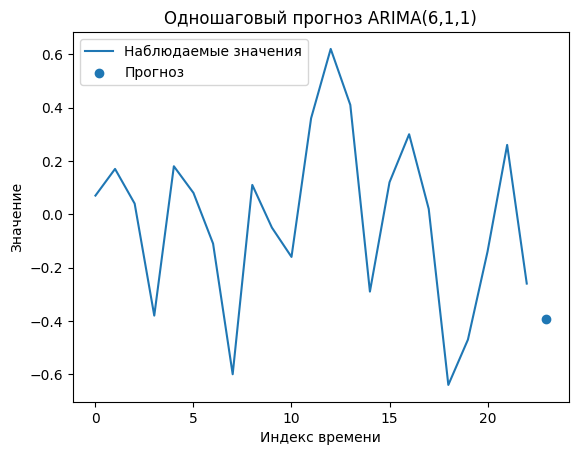

In [190]:

y = np.array([ 0.07,  0.17,  0.04, -0.38,  0.18,  0.08, -0.11, -0.6 ,  0.11,
              -0.05, -0.16,  0.36,  0.62,  0.41, -0.29,  0.12,  0.3 ,  0.02,
              -0.64, -0.47, -0.14,  0.26, -0.26])
phi = np.array([ 0.86970325, -0.40143956, -0.02909814,  0.46750285,
                -0.66175898, -0.07364059])
theta = -0.709529691506917
resid = np.array([ 0.08565217,  0.17193296,  0.05056559, -0.29985047,  0.28747433,
                   -0.04529167, -0.03858501, -0.26474524,  0.08244498, -0.26453032,
                   -0.1469147 ,  0.60461191,  0.22660197,  0.23638307, -0.15670525,
                    0.17876493,  0.16755782,  0.17580702,  0.0567955 , -0.06117996,
                   -0.10021193,  0.31434167,  0.01453486])

# Вычисление прогноза
dy = y
p = len(phi)
ar_term = sum(phi[i] * dy[-i-1] for i in range(p))
ma_term = theta * resid[-1]
delta_forecast = ar_term + ma_term
y_forecast = y[-1] + delta_forecast

print("Прогноз Δy:", delta_forecast)
print("Прогноз y:", y_forecast)

# Построение графика
plt.figure()
plt.plot(np.arange(len(y)), y, label='Наблюдаемые значения')
plt.scatter([len(y)], [y_forecast], label='Прогноз', zorder=5)
plt.legend()
plt.title('Одношаговый прогноз ARIMA(6,1,1)')
plt.xlabel('Индекс времени')
plt.ylabel('Значение')
plt.show()


In [193]:
crona

array([45.27, 45.34, 45.51, 45.55, 45.17, 45.35, 45.43, 45.32, 44.72,
       44.83, 44.78, 44.62, 44.98, 45.6 , 46.01, 45.72, 45.84, 46.14,
       46.16, 45.52, 45.05, 44.91, 45.17, 44.91])

In [200]:
diffs =[]

for i in range(len(crona)-1):
    diffs.append((crona[i+1]- crona[i])/crona[i])

In [201]:
diffs = np.array(diffs)

In [204]:
diffs

array([ 0.00154628,  0.00374945,  0.00087893, -0.00834248,  0.00398495,
        0.00176406, -0.00242131, -0.01323919,  0.00245975, -0.00111532,
       -0.00357302,  0.00806813,  0.0137839 ,  0.00899123, -0.00630298,
        0.00262467,  0.0065445 ,  0.00043346, -0.01386482, -0.01032513,
       -0.00310766,  0.00578936, -0.00575603])

In [202]:
results = []
for k in [5, 10, 15]:
    segment = diffs[-k:]
    mean_k = segment.mean()
    var_k = segment.var(ddof=0)  # смещённая оценка
    results.append({'k': k, 'mean': mean_k, 'variance': var_k})


In [203]:
results

[{'k': 5, 'mean': -0.0054528568532819415, 'variance': 4.5295877485302945e-05},
 {'k': 10, 'mean': -0.0014973395903640058, 'variance': 5.23204384932959e-05},
 {'k': 15, 'mean': 0.0003100026839153766, 'variance': 5.4622311840123134e-05}]

In [249]:
# Параметры GARCH(1,1)
omega = 4.8e-05
alpha = 0.04
beta  = 0.89

T = len(diffs)
# Инициализация sigma^2   
sigma2 = np.empty(T)
# Начальное значение взято условной несмещённой дисперсии ω/(1-α-β)
sigma2[0] = omega / (1 - alpha - beta)

# Рекуррентное вычисление σ²_t
for t in range(1, T):
    sigma2[t] = omega + alpha * diffs[t-1]**2 + beta * sigma2[t-1]

# Серии для анализа
u2      = diffs**2
std_u2  = u2 / sigma2

# Функция расчёта автокорреляции
def acf(x, lag):
    return np.corrcoef(x[:-lag], x[lag:])[0,1]

lags = list(range(1,6))
acf_u2     = [acf(u2,      k) for k in lags]
acf_std_u2 = [acf(std_u2,  k) for k in lags]

# Собираем в DataFrame
df = pd.DataFrame({
    'lag': lags,
    'ACF(u^2)': acf_u2,
    'ACF(u^2/σ^2)': acf_std_u2
})


In [250]:
sigma2

array([0.00068571, 0.00065838, 0.00063452, 0.00061276, 0.00059614,
       0.0005792 , 0.00056361, 0.00054985, 0.00054437, 0.00053274,
       0.00052218, 0.00051325, 0.0005074 , 0.00050719, 0.00050263,
       0.00049693, 0.00049054, 0.0004863 , 0.00048081, 0.00048361,
       0.00048268, 0.00047797, 0.00047473])

In [248]:
df.values

array([[ 1.00000000e+00,  5.72539047e-02,  9.18016433e-02],
       [ 2.00000000e+00, -2.48541745e-01, -2.21873568e-01],
       [ 3.00000000e+00, -3.20230507e-01, -2.93161310e-01],
       [ 4.00000000e+00, -3.89728936e-03, -2.15009604e-02],
       [ 5.00000000e+00,  2.77691497e-01,  2.87135367e-01]])

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                81.7741
Distribution:                  Normal   AIC:                          -155.548
Method:            Maximum Likelihood   BIC:                          -151.006
                                        No. Observations:                   23
Date:                Thu, Jun 12 2025   Df Residuals:                       22
Time:                        14:49:45   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -3.2897e-04  4.909e-06    -67.019     

C:\Users\Arseny\AppData\Roaming\Python\Python312\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.806e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


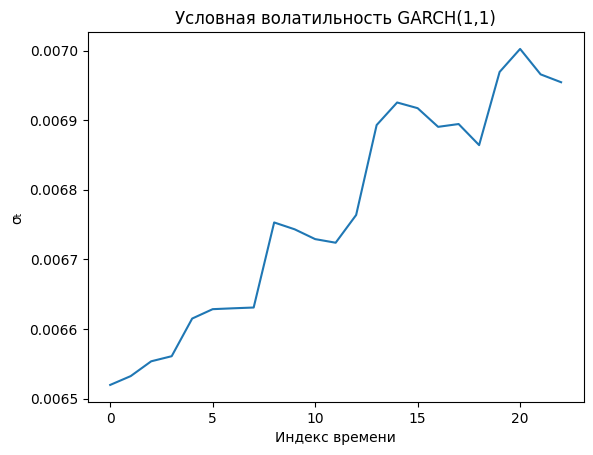

In [233]:
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model


# 1. Задаём модель GARCH(1,1) с нормальным распределением ошибок
am = arch_model(diffs, vol='Garch', p=1, q=1, dist='normal')

# 2. Оцениваем модель
res = am.fit(disp='off')

# 3. Смотрим результаты
print(res.summary())

# 4. Строим условную волатильность
plt.figure()
plt.plot(res.conditional_volatility)
plt.title('Условная волатильность GARCH(1,1)')
plt.xlabel('Индекс времени')
plt.ylabel('σₜ')
plt.show()


In [237]:
df

,Series,Q(m=5),p-value
0,u^2,7.189099,0.206952
1,u^2/σ^2,6.686754,0.244998


In [235]:

lags = df.values[:,0].astype(int)
acf_u2 = df.values[:,1]
acf_std = df.values[:,2]

T = 23  # длина рядов

# Функция для вычисления статистики Ljung-Box
def ljung_box(acf, T, m):
    # Q = T*(T+2) * sum_{k=1}^m acf_k^2/(T-k)
    return T*(T+2) * np.sum(acf[:m]**2 / (T - lags[:m]))

# Вычисляем Q и p-values для m = 5
m = 5
Q_u2 = ljung_box(acf_u2, T, m)
Q_std = ljung_box(acf_std, T, m)
pval_u2 = 1 - chi2.cdf(Q_u2, df=m)
pval_std = 1 - chi2.cdf(Q_std, df=m)

df = pd.DataFrame({
    'Series': ['u^2', 'u^2/σ^2'],
    'Q(m=5)': [Q_u2, Q_std],
    'p-value': [pval_u2, pval_std]
})

In [236]:
df

,Series,Q(m=5),p-value
0,u^2,7.189099,0.206952
1,u^2/σ^2,6.686754,0.244998


In [ ]:
def auto_covar_k(k, crona):
  mean = np.sum(crona)/len(crona)
  return np.dot((crona[:len(crona)-k]-mean),(crona[k:]-mean))/len(crona)


In [261]:

corr1 = [] # Последовательность автокорреляций до порядка 5 включительно для ряда u^2(n)
for i in range(1,6):
  corr1.append(auto_covar_k(i, np.array(diffs)**2)/auto_covar_k(0, np.array(diffs)**2))
  print(f"r{i} = {corr1[i-1]}")
np.array(corr1)

r1 = 0.05679467889450331
r2 = -0.24116173978242203
r3 = -0.29878886734385574
r4 = -0.0029744791319836947
r5 = 0.20492609763441882


array([ 0.05679468, -0.24116174, -0.29878887, -0.00297448,  0.2049261 ])

In [262]:

prir2 = [diffs[i]**2/sigma2[i] for i in range(1,len(prir))] # Последовательность u^2(n)/sigma^2(n)
corr2 = []
for i in range(1,6):
  corr2.append(auto_covar_k(i, prir2)/auto_covar_k(0, prir2))
  print(f"r{i} = {corr2[i-1]}")

np.array(corr2)

r1 = 0.07024718555216344
r2 = -0.2513025783304572
r3 = -0.28022733093747226
r4 = -0.04374006111779579
r5 = 0.17943996338574317


array([ 0.07024719, -0.25130258, -0.28022733, -0.04374006,  0.17943996])

In [270]:

T = 24  # длина рядов

# Функция для вычисления статистики Ljung-Box
def ljung_box(acf, T, m):
    lags = np.arange(m)
    return T*(T+2) * np.sum(np.power(acf[:m],2)/ (T - lags[:m]))

# Вычисляем Q и p-values для m = 5
m = 5
Q_u2 = ljung_box(corr1, T, m)
Q_std = ljung_box(corr2, T, m)
pval_u2 = 1 - chi2.cdf(Q_u2, df=m)
pval_std = 1 - chi2.cdf(Q_std, df=m)

df = pd.DataFrame({
    'Series': ['u^2', 'u^2/σ^2'],
    'Q(m=5)': [Q_u2, Q_std],
    'p-value': [pval_u2, pval_std]})

In [271]:
df

,Series,Q(m=5),p-value
0,u^2,5.504400,0.357464
1,u^2/σ^2,5.130439,0.400170


In [272]:


# Параметры вашей GARCH(1,1)
omega = 4.8e-06
alpha = 0.01
beta  = 0.89

T = len(diffs)

# Инициализируем массив условной дисперсии
sigma2 = np.empty(T)
# Берём стационарное начальное значение
sigma2[0] = omega / (1 - alpha - beta)

# Рассчитываем σ²_t по рекурсии
for t in range(1, T):
    sigma2[t] = omega + alpha * diffs[t-1]**2 + beta * sigma2[t-1]

# Одноступенчатый прогноз условной дисперсии σ²_{T+1}
sigma2_next = omega + alpha * diffs[-1]**2 + beta * sigma2[-1]

print(f"Последняя оценка σ²_T = {sigma2[-1]:.8f}")
print(f"Прогноз σ²_{{T+1}} = {sigma2_next:.8f}")

Последняя оценка σ²_T = 0.00004876
Прогноз σ²_{T+1} = 0.00004853


In [273]:
omega, alpha, beta = 4.8e-06, 0.01, 0.89

# рассчёт прогнозной дисперсии σ²_{T+1}
pred_sigma2 = omega + alpha * corr1[-1] + beta * prir2[-1]

# прогноз цены как y_T плюс прогноз дисперсии
predict = crona[-1] + pred_sigma2

print(f'Прогноз цены y_(T+1) = {predict}')


Прогноз цены y_(T+1) = 44.97416759294688


Text(0.5, 1.0, 'Предсказание модели GARCH(1,1)')

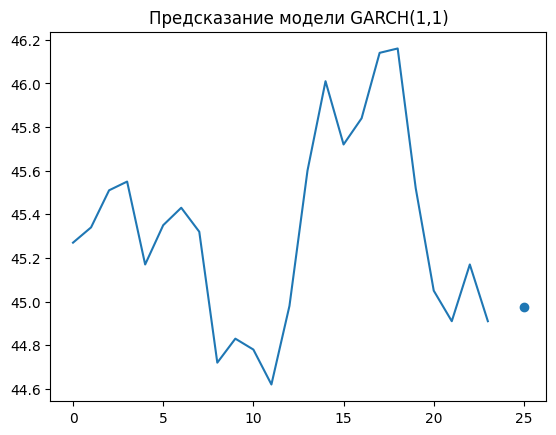

In [277]:
plt.plot(crona)
plt.scatter(25, predict)
plt.title("Предсказание модели GARCH(1,1)")

In [278]:
crona

array([45.27, 45.34, 45.51, 45.55, 45.17, 45.35, 45.43, 45.32, 44.72,
       44.83, 44.78, 44.62, 44.98, 45.6 , 46.01, 45.72, 45.84, 46.14,
       46.16, 45.52, 45.05, 44.91, 45.17, 44.91])